## 初始化

In [1]:

import torch
from model import Model, device
from eeg_dataset import EEG_Dataset
import numpy as np

# 从分类结果获得显著图
dataset = EEG_Dataset(path='C:/Users/14152/Desktop/eegbin/dataset',symmetry=True)
m1 = Model(8, 5,PSD_en=True,PLV_en=False).to(device)
m2 = Model(8, 5,PSD_en=False,PLV_en=True).to(device)
state_dict1 = torch.load('C:/Users/14152/Desktop/eegbin/log/best_dispose_0_PSD_True_PLV_False.pth')
state_dict2 = torch.load('C:/Users/14152/Desktop/eegbin/log/best_dispose_0_PSD_False_PLV_True.pth')
m1.load_state_dict(state_dict1)
m2.load_state_dict(state_dict2)

m1.eval()
m2.eval()


Loaded files: ['co_1_1.npz', 'co_1_2.npz', 'co_3_1.npz', 'co_3_2.npz', 'vs_1_1.npz', 'vs_2_1.npz', 'vs_3_1.npz']
Total entries: 16724
co count: 4103
vs count: 4259


Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_c): Linear(in_features=4096, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

## 样本前向计算

合作：[0.6, 0.4]
对抗：[0.4, 0.6]

In [32]:

from tqdm import trange
# 初始化存储显著值的字典
saliency_dict = {i: [] for i in range(2)}  # 假设有5个类别
val_dict =  {i: [] for i in range(2)}
# 遍历整个数据集
for i in trange(len(dataset)):
    (x1, x2), y = dataset[i]
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)
    x1.requires_grad_(), x2.requires_grad_()
    truth = y.argmax().item()

    output1 = m1(x1, x2)
    prediction1 = output1.argmax().item()
    
    
    m1_True = prediction1 == truth

    if m1_True:
        m1.zero_grad()
        output1[0, prediction1].backward()
        saliency_x1 = x1.grad.data.abs().squeeze(0).cpu().detach().numpy()
    
    (x1, x2), y = dataset[i]
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)
    x1.requires_grad_(), x2.requires_grad_()
    output2 = m2(x1, x2)
    prediction2 = output2.argmax().item()
    m2_True = prediction2 == truth
    if m2_True:
        m2.zero_grad()
        output2[0, prediction1].backward()
        saliency_x2 = x2.grad.data.abs().squeeze(0).cpu().detach().numpy()
        
    
    if m1_True and m2_True:
        saliency_dict[truth].append((saliency_x1, saliency_x2))
        val_dict[truth].append((x1.squeeze(0).cpu().detach().numpy(),x2.squeeze(0).cpu().detach().numpy()))

# 计算输入均值

# 计算每个类的平均显著值
avg_saliency_dict = {}
avg_val_dict = {}
for key, saliencies in saliency_dict.items():
    if saliencies:
        avg_saliency_x1 = np.mean([s[0] for s in saliencies], axis=0)
        avg_saliency_x2 = np.mean([s[1] for s in saliencies], axis=0)
        avg_saliency_dict[key] = (avg_saliency_x1, avg_saliency_x2)

for key, vals in val_dict.items():
    if vals:
        avg_x1 = np.mean([v[0] for v in vals], axis=0)
        avg_x2 = np.mean([v[1] for v in vals], axis=0)
        avg_val_dict[key] = (avg_x1,avg_x2)
        



100%|██████████| 16724/16724 [01:31<00:00, 182.12it/s]


## 可视化显著性

saliency of PLV for class 0


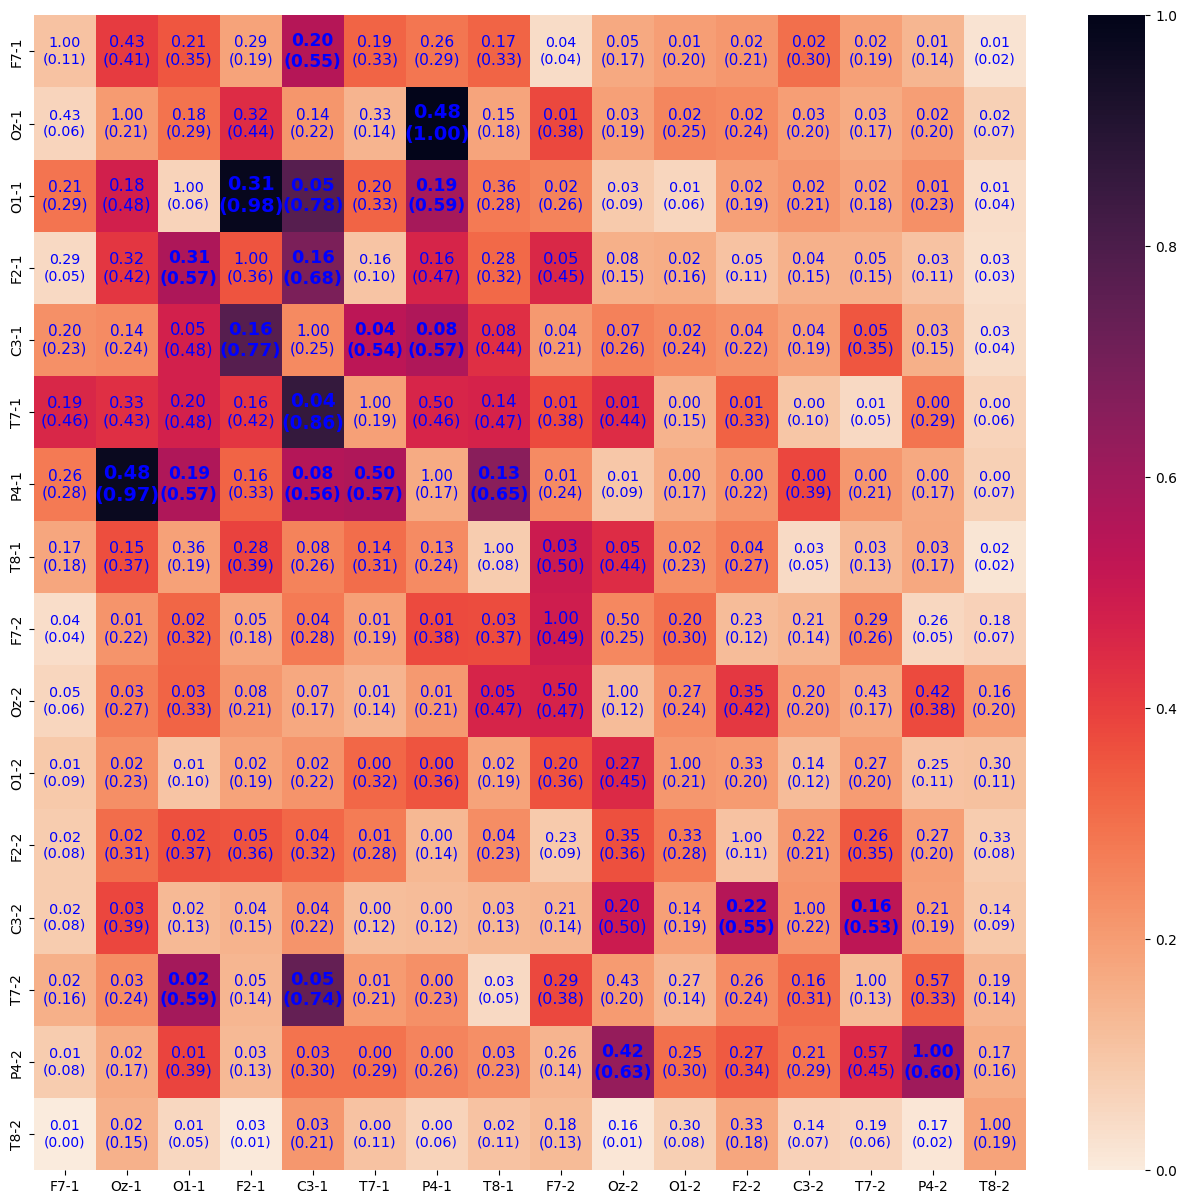

saliency of ENG for class 0


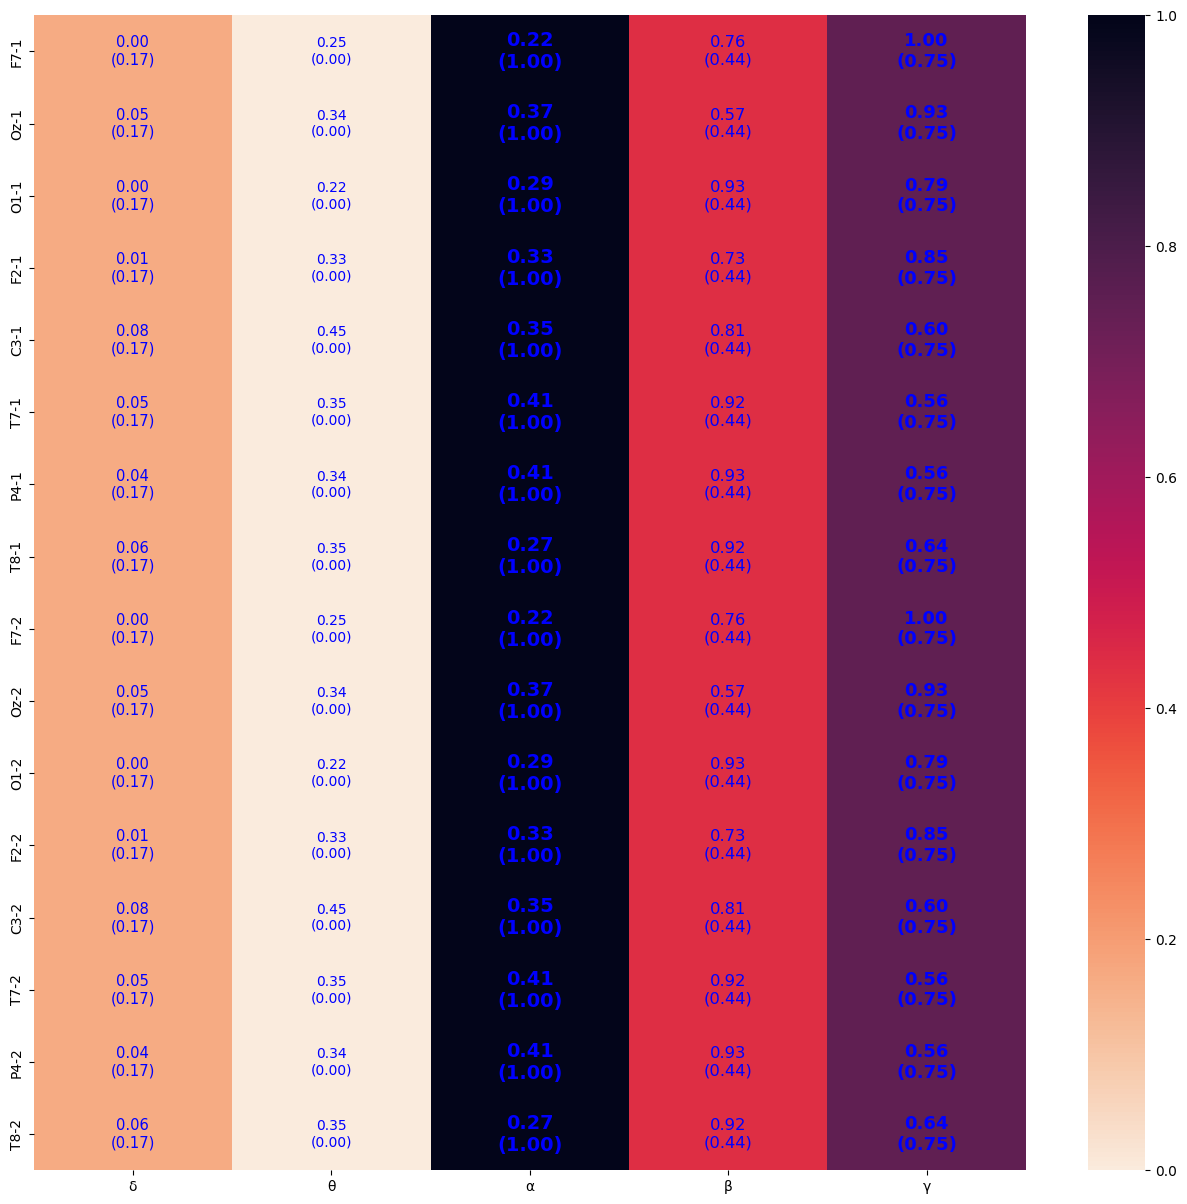

saliency of PLV for class 1


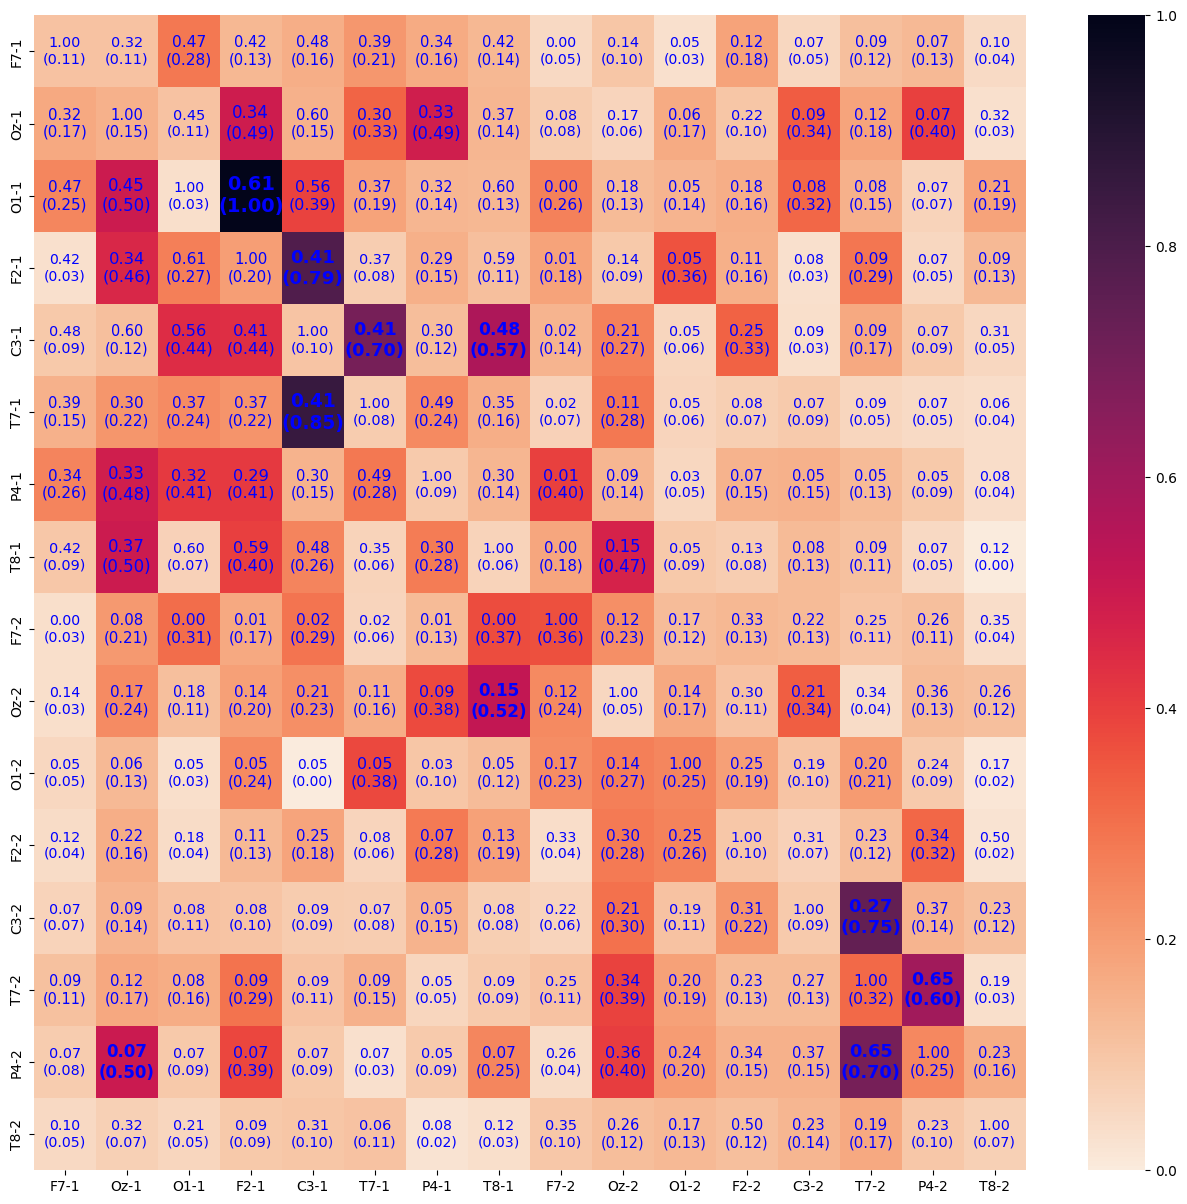

saliency of ENG for class 1


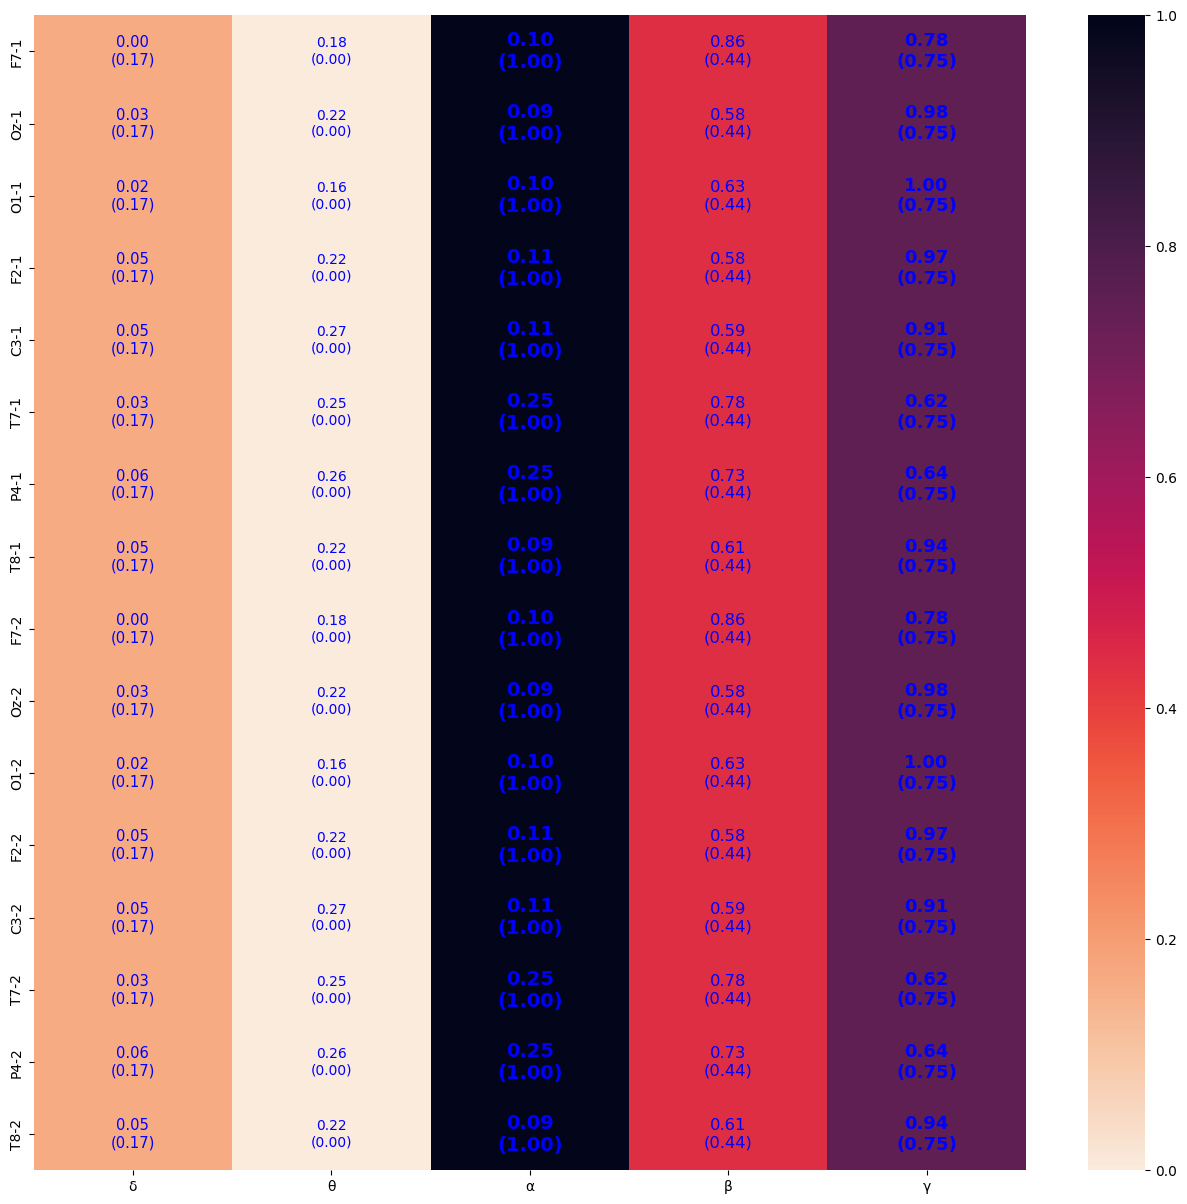

same brain
$P4_2 \leftrightarrow P4_2$ & 0.60 & $1.00\downarrow$ & 0.25 & $1.00\uparrow$ \\
cross brain
$C3_1 \leftrightarrow F7_1$ & 0.55 & $0.20\downarrow$ & 0.16 & $0.48\uparrow$ \\
$P4_1 \leftrightarrow Oz_1$ & 1.00 & $0.48\uparrow$ & 0.49 & $0.33\downarrow$ \\
$F2_1 \leftrightarrow O1_1$ & 0.98 & $0.31\downarrow$ & 1.00 & $0.61\uparrow$ \\
$C3_1 \leftrightarrow O1_1$ & 0.78 & $0.05\downarrow$ & 0.44 & $0.56\uparrow$ \\
$P4_1 \leftrightarrow O1_1$ & 0.59 & $0.19\downarrow$ & 0.41 & $0.32\uparrow$ \\
$C3_1 \leftrightarrow F2_1$ & 0.77 & $0.16\downarrow$ & 0.79 & $0.41\uparrow$ \\
$T7_1 \leftrightarrow C3_1$ & 0.86 & $0.04\downarrow$ & 0.85 & $0.41\uparrow$ \\
$P4_1 \leftrightarrow C3_1$ & 0.57 & $0.08\downarrow$ & 0.15 & $0.30\uparrow$ \\
$T7_1 \leftrightarrow P4_1$ & 0.57 & $0.50\uparrow$ & 0.28 & $0.49\downarrow$ \\
$T8_1 \leftrightarrow P4_1$ & 0.65 & $0.13\downarrow$ & 0.28 & $0.30\uparrow$ \\
$F2_2 \leftrightarrow C3_2$ & 0.55 & $0.22\downarrow$ & 0.22 & $0.31\uparrow$ \\
$T7_2

In [42]:

from matplotlib import pyplot as plt
# from utils.plot_relation_map import plot_weighted_heatmap
import seaborn as sns

plv_cmp = {}


def plot_weighted_heatmap(A, B,xticklabels, yticklabels,cmp = False):
    # Define the figure and axis
    fig, ax = plt.subplots(figsize=(16, 15))

    # Create the heatmap for matrix A
    sns.heatmap(B, annot=False, cmap="rocket_r", cbar=True, ax=ax,xticklabels=xticklabels, yticklabels=yticklabels)

    # Annotate each cell with values from A and B in the format 'val_A(val_B)'
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            value = A[i, j]
            weight = B[i, j]
            size = 10 + (weight * 4)  # Adjust font size based on weight
            if weight > 0.5:
                fontweight = 'bold' 
                if cmp:
                    if (j,i) not in plv_cmp.keys() and (i,j) not in plv_cmp.keys():
                        plv_cmp[(j,i)] = np.zeros((4))
            else:
                fontweight = 'normal'
            ax.text(j + 0.5, i + 0.5, f'{value:.2f}\n({weight:.2f})',color ='blue', ha='center', va='center', fontsize=size,fontweight = fontweight )

    # Adjust the axis
    ax.set_xticks(np.arange(A.shape[1]) + 0.5)
    ax.set_yticks(np.arange(A.shape[0]) + 0.5)
    plt.show()

# 归一化函数
def normalize_matrix(matrix):
    matrix = np.array(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

coords_ch = ['F7-1', 'Oz-1', 'O1-1', 'F2-1', 'C3-1', 'T7-1', 'P4-1', 'T8-1', 'F7-2', 'Oz-2', 'O1-2', 'F2-2', 'C3-2', 'T7-2', 'P4-2', 'T8-2']
coords_band = ['δ', 'θ', 'α', 'β', 'γ']

# 对每种y的平均显著值进行可视化
for key, (avg_saliency_x1, avg_saliency_x2) in avg_saliency_dict.items():
    normalized_saliency_x1 = normalize_matrix(avg_saliency_x1)
    normalized_saliency_x2 = normalize_matrix(avg_saliency_x2)
    normalized_x1 = normalize_matrix(avg_val_dict[key][0])
    normalized_x2 = normalize_matrix(avg_val_dict[key][1])

    
    
    print(f'saliency of PLV for class {key}')
    plot_weighted_heatmap(normalized_x2,normalized_saliency_x2, coords_ch, coords_ch,True)
    
    print(f'saliency of ENG for class {key}')
    plot_weighted_heatmap(normalized_x1,normalized_saliency_x1, coords_band, coords_ch)

    for k in plv_cmp.keys():
        j,i = k
        plv_cmp[k][key*2] = max(normalized_saliency_x2[j,i],normalized_saliency_x2[i,j])
        plv_cmp[k][key*2+1] = normalized_x2[j,i]

# 输出比较值
print("same brain")
for k,v in plv_cmp.items():
    j,i = k
    arr1,arr2 = ('\\uparrow','\\downarrow') if v[1] > v[3] else('\\downarrow','\\uparrow')
    if i == j:
        continue
    if coords_ch[j][-1:] == coords_ch[i][-1:]:
        print(f"${coords_ch[j].replace('-','_')} \\leftrightarrow {coords_ch[i].replace('-','_')}$ & {v[0]:.2f} & ${v[1]:.2f}{arr1}$ & {v[2]:.2f} & ${v[3]:.2f}{arr2}$ \\\\")
print("cross brain")
for k,v in plv_cmp.items():
    j,i = k
    if i == j:
        continue
    arr1,arr2 = ('\\uparrow','\\downarrow') if v[1] > v[3] else('\\downarrow','\\uparrow')
    if coords_ch[j][-1:] != coords_ch[i][-1:]:
        print(f"${coords_ch[j].replace('-','_')} \\leftrightarrow {coords_ch[i].replace('-','_')}$ & {v[0]:.2f} & ${v[1]:.2f}{arr1}$ & {v[2]:.2f} & ${v[3]:.2f}{arr2}$ \\\\")

## 使用mne绘制能量图与连接图

Relation Map for class 0


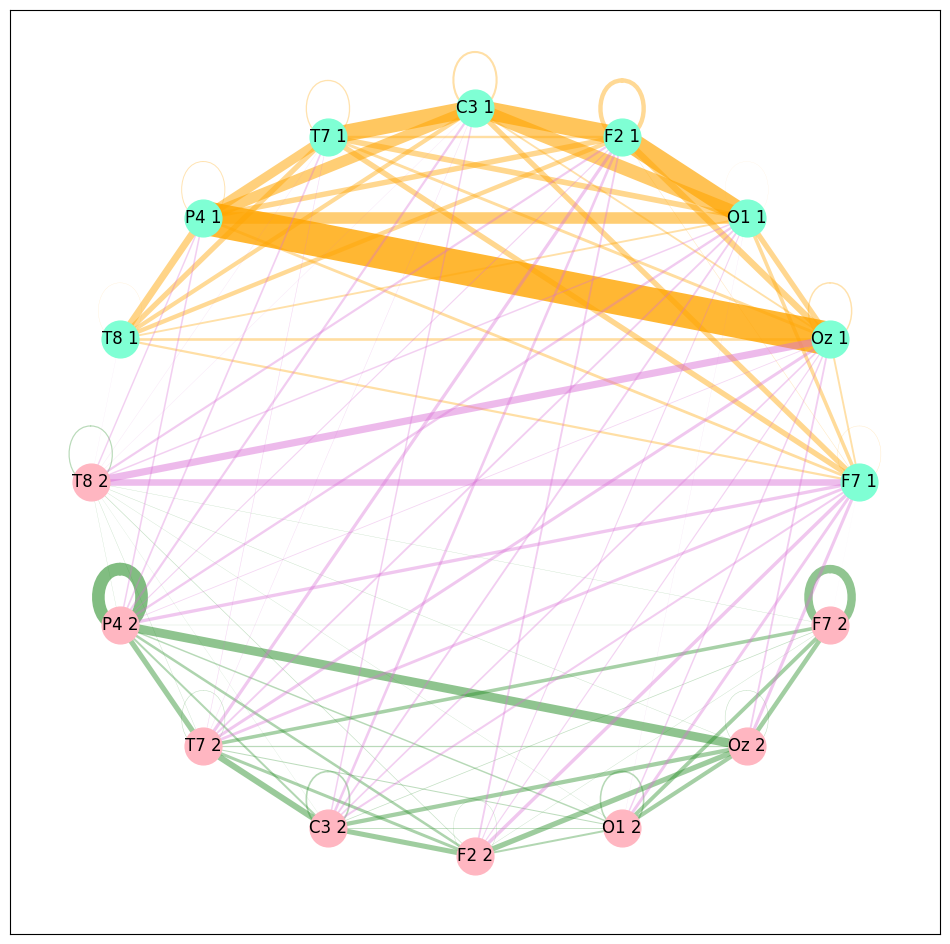

Relation Map for class 1


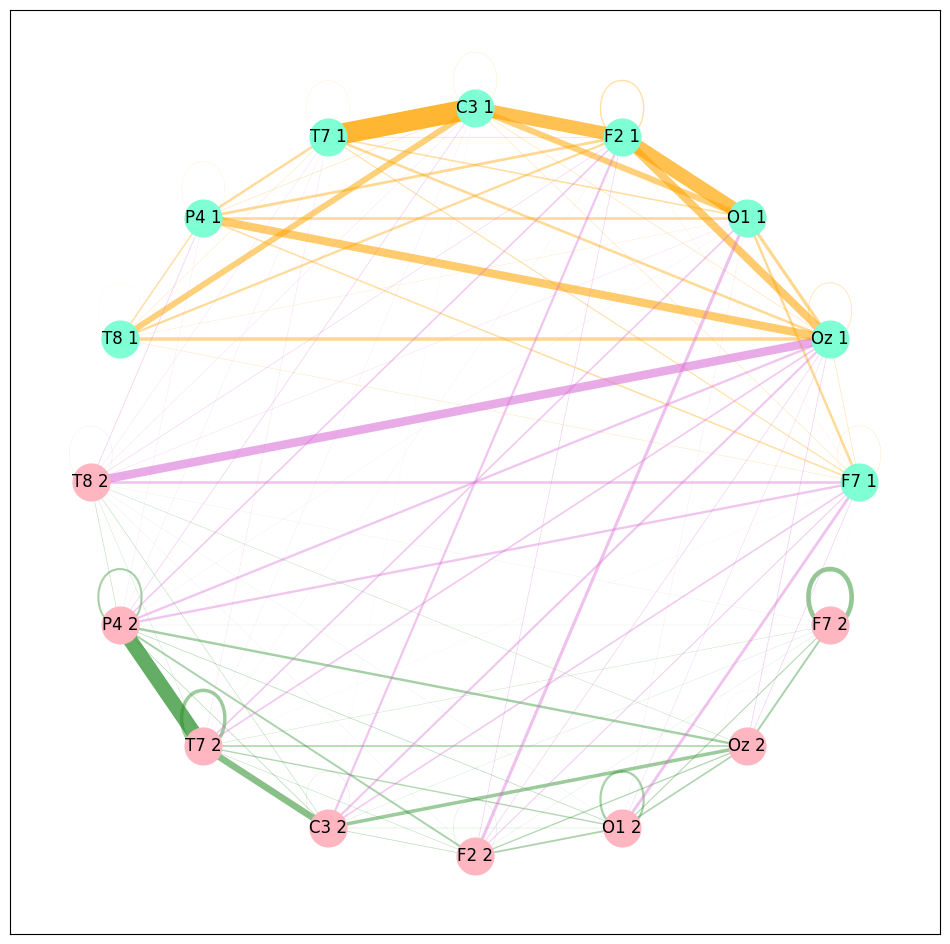

In [4]:

from utils.plot_relation_map import plot_relation_map
node_names = ['F7', 'Oz', 'O1', 'F2', 'C3', 'T7', 'P4', 'T8']

# 对每种y的平均显著值绘制连接图
for key, (_, avg_saliency_x2) in avg_saliency_dict.items():
    print(f'Relation Map for class {key}')
    plot_relation_map(normalize_matrix(avg_saliency_x2), node_names)
